Text(0.5,1,u'Power spectrogram')

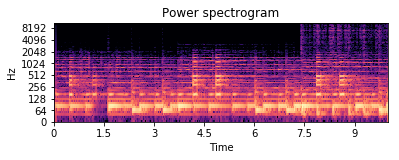

In [3]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(16.0, 4.0))
y, sr = librosa.load(librosa.util.example_audio_file(),
                      duration=10.0)
D = librosa.stft(y)
times = librosa.frames_to_time(np.arange(D.shape[1]))
plt.figure()
ax1 = plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')

In [7]:

import numpy as np



def from_hz(frequencies):
    # Convert an array of frequencies to an array of Mel bin numbers.
    frequencies = np.asanyarray(frequencies)

    # Fill in the linear part
    f_min = 0.0
    f_sp = 200.0 / 3
    mels = (frequencies - f_min) / f_sp

    # Fill in the log-scale part
    min_log_hz = 1000.0                         # beginning of log region (Hz)
    min_log_mel = (min_log_hz - f_min) / f_sp   # same (Mels)
    logstep = np.log(6.4) / 27.0                # step size for log region

    if frequencies.ndim:
        # If we have array data, vectorize
        log_t = (frequencies >= min_log_hz)
        mels[log_t] = min_log_mel + np.log(frequencies[log_t]/min_log_hz) / logstep
    elif frequencies >= min_log_hz:
        # If we have scalar data, heck directly
        mels = min_log_mel + np.log(frequencies / min_log_hz) / logstep

    return mels


def to_hz(mels):
    # Convert mel bins to frequency values.
    mels = np.asanyarray(mels)

    # Fill in the linear scale
    f_min = 0.0
    f_sp = 200.0 / 3
    freqs = f_min + f_sp * mels

    # And now the nonlinear scale
    min_log_hz = 1000.0                         # beginning of log region (Hz)
    min_log_mel = (min_log_hz - f_min) / f_sp   # same (Mels)
    logstep = np.log(6.4) / 27.0                # step size for log region

    if mels.ndim:
        # If we have vector data, vectorize
        log_t = (mels >= min_log_mel)
        freqs[log_t] = min_log_hz * np.exp(logstep * (mels[log_t] - min_log_mel))
    elif mels >= min_log_mel:
        # If we have scalar data, check directly
        freqs = min_log_hz * np.exp(logstep * (mels - min_log_mel))

    return freqs


def frequencies(n_mels=128, fmin=0.0, fmax=22050.0):
    """ Compute the center frequencies for an array of mel bands."""
    mels = np.linspace(from_hz(fmin), from_hz(fmax), n_mels)
    return to_hz(mels)


_cache = {}

def filter(samplerate, in_size, num_bands=40, fmin=0.0, fmax=22050.0):
    """
    Create a filterbank which will merge FFT bins into Mel-scaled bins.
    samplerate - original sampling frequency in Hz
    in_size - number of bins in the input spectrum
    num_bands - number of mel bands to generate
    fmin, fmax - cutoff frequency range
    """

    # Upper frequency is limited by Nyquist regardless of parameter setttings.
    nyquistmax = float(samplerate) / 2.0
    fmax = min(fmax, nyquistmax)

    existing = _cache.get((samplerate, in_size, num_bands, fmin, fmax), None)
    if existing is not None: return existing

    # Initialize the weights
    in_size, num_bands = int(in_size), int(num_bands)
    weights = np.zeros((num_bands, in_size))

    # Compute the center frequencies for the FFT bins and the mel bands
    fft_freqs = np.linspace(0, nyquistmax, in_size, endpoint=True)
    mel_freqs = frequencies(num_bands + 2, fmin=fmin, fmax=fmax)

    # Generate triangular ramps for the band filters
    fdiff = np.diff(mel_freqs)
    ramps = np.subtract.outer(mel_freqs, fft_freqs)
    for i in range(num_bands):
        lower = -ramps[i] / fdiff[i]
        upper = ramps[i+2] / fdiff[i+1]
        weights[i] = np.maximum(0, np.minimum(lower, upper))

    # Normalize energy level per channel
    enorm = 2.0 / (mel_freqs[2:num_bands + 2] - mel_freqs[:num_bands])
    weights *= enorm[:, np.newaxis]

    _cache[(samplerate, in_size, num_bands, fmin, fmax)] = weights
    return weights




def amp_to_power(s):
    return s ** 2.0


def power_to_db(s):
    log_s = 10.0 * np.log10(np.maximum(1e-10, s))
    return log_s - 10.0 * np.log10(np.maximum(1e-10, 1.0))


def hz_to_mel(spectrum, samplerate, num_bands=40):
    return np.dot(spectrum, filter(samplerate, len(spectrum), num_bands).T)


def _windows(source, samplerate, resolution=128, window_size=2048):
    # Yield a sequence of views onto the source, which must be normalized mono.
    # We'll pad the beginning by half a window so that time zero happens at
    # index zero, and we'll pad the end by whatever we need to line things up.
    mask = np.hamming(window_size)
    for i in range(0, len(source), resolution):
        start = i - (window_size / 2)
        stop = start + window_size
        frame = None
        if start < 0:
            frame = np.zeros(window_size)
            frame[-start:] = source[0:stop]
        elif stop > len(source):
            frame = np.zeros(window_size)
            frame[:len(source)-stop] = source[start:]
        else:
            frame = source[start:stop]
        yield frame * mask


def analyze(sound):
    print "Analyzing"

    samples = y#sound.frames
    samplerate = sr#sound.samplerate

    # Prepare for analysis by mixing down to a single channel, if necessary.
    if samples.ndim > 1:
        samples = np.mean(samples, axis=1)

    # The ultimate goal of this analysis will be to generate a beat grid and
    # segmentation points. In order to run the beat tracker, we will need an
    # array of onset strengths; we generate that by computing a variety of
    # frequency-level features.  Begin with a mel-scaled spectrogram.

    # Compute sliding windowed FFTs.
    frames = _windows(samples, samplerate, resolution=256, window_size=2048)
    spectrogram = (np.abs(np.fft.rfft(f)) for f in frames)
    # Convert to power spectrum and then rescale to Mel bands.
    melbands = (hz_to_mel(amp_to_power(s), samplerate) for s in spectrogram)
    melbands = (power_to_db(m) for m in melbands)
    # Compute the cosine difference between each pair of spectra.
    librosa.display.specshow(np.array([melbands]))

analyze(None)


Analyzing


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''